In [3]:
import os
import tensorflow as tf
os.environ['KERAS_BACKEND'] = 'tensorflow'

import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
        
PATH = 'input'

train_ids = next(os.walk(os.path.join(PATH, 'train', 'images')))[2]
test_ids = next(os.walk(os.path.join(PATH, 'test', 'images')))[2]

In [6]:
im_width = 128
im_height = 128
border = 5
im_chan = 1 
n_features = 1 # Number of extra features, like depth
df_depths = pd.read_csv('input/depths.csv', index_col='id')

In [37]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)

print('Getting and resizing train images and masks ... ')

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    img = load_img(os.path.join(PATH, 'train', 'images', id_))
                   
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    X_feat[n] = df_depths.loc[id_.replace('.png', ''), 'z']
    
    mask = img_to_array(load_img(os.path.join(PATH, 'train', 'masks', id_)))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

  0%|          | 0/4000 [00:00<?, ?it/s]/opt/miniconda2/envs/avito/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
  0%|          | 18/4000 [00:00<00:22, 174.59it/s]

Getting and resizing train images and masks ... 


100%|██████████| 4000/4000 [00:11<00:00, 341.28it/s]

Done!


In [8]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [142]:
def build_unet_model():
    # Build U-Net model
    inputs1 = Input((im_height, im_width, im_chan), name='inputs1')
    #inputs2 = Input((n_features,), name='inputs2')
    
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs1)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    # Join features information in the depthest layer
    #f_repeat = RepeatVector(8*8)(inputs2)
    #f_conv = Reshape((8, 8, n_features))(f_repeat)
    #p4_feat = concatenate([p4, f_conv], -1)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs1], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [38]:
X_train = X_train.astype(np.float32)/ 255
X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X_train, X_feat, Y_train, test_size=0.25, random_state=1)

In [39]:
X_train.shape, X_valid.shape, X_feat_train.shape

((3000, 128, 128, 2), (1000, 128, 128, 2), (3000, 1))

In [40]:
x_feat_mean = X_feat_train.mean(axis=0, keepdims=True)
x_feat_std = X_feat_train.std(axis=0, keepdims=True)
X_feat_train -= x_feat_mean
X_feat_train /= x_feat_std

X_feat_valid -= x_feat_mean
X_feat_valid /= x_feat_std

In [163]:
model = build_unet_model()

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(patience=5, verbose=1),
    ModelCheckpoint('model-tgs-salt-0.h5', verbose=1, save_best_only=True)
]

data_gen_args = dict(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(X_train, batch_size=32, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=32, seed=seed)    
train_generator = zip(image_generator, mask_generator)

results = model.fit_generator(
    train_generator, 
    epochs=100, 
    steps_per_epoch=len(X_train)//32,
    callbacks=callbacks,
    validation_data=({'inputs1': X_valid}, y_valid))

/opt/miniconda2/envs/avito/lib/python3.6/site-packages/keras/preprocessing/image.py:748: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (3000, 128, 128, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
/opt/miniconda2/envs/avito/lib/python3.6/site-packages/keras/preprocessing/image.py:935: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (3000, 128, 128, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/100
93/93 [==============================] - 13s 137ms/step - loss: 0.5703 - val_loss: 0.4889

Epoch 00001: val_loss improved from inf to 0.48894, saving model to model-tgs-salt-0.h5
Epoch 2/100
93/93 [==============================] - 10s 105ms/step - loss: 0.5181 - val_loss: 0.4701

Epoch 00002: val_loss improved from 0.48894 to 0.47012, saving model to model-tgs-salt-0.h5
Epoch 3/100
93/93 [==============================] - 10s 111ms/step - loss: 0.4463 - val_loss: 0.3958

Epoch 00003: val_loss improved from 0.47012 to 0.39582, saving model to model-tgs-salt-0.h5
Epoch 4/100
93/93 [==============================] - 11s 113ms/step - loss: 0.4188 - val_loss: 0.3932

Epoch 00004: val_loss improved from 0.39582 to 0.39322, saving model to model-tgs-salt-0.h5
Epoch 5/100
93/93 [==============================] - 11s 114ms/step - loss: 0.3883 - val_loss: 0.3361

Epoch 00005: val_loss improved from 0.39322 to 0.33610, saving model to model-tgs-salt-0.h5
Epoch 6/100
93/93 [==========

In [46]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
X_test_feat = np.zeros((len(test_ids), n_features), dtype=np.float32)

print('Getting and resizing test images ... ')

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = load_img(os.path.join(PATH, 'test', 'images', id_))
    x = img_to_array(img)[:,:,1]    
    x = resize(x, (im_height, im_width, 1), mode='constant', preserve_range=True)
    X_test[n] = x
    X_test_feat[n] = df_depths.loc[id_.replace('.png', ''), 'z']

X_test = X_test.astype(np.float32)/ 255.
print('Done!')

  0%|          | 0/18000 [00:00<?, ?it/s]/opt/miniconda2/envs/avito/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
  0%|          | 33/18000 [00:00<00:55, 326.10it/s]

Getting and resizing test images ... 


100%|██████████| 18000/18000 [00:29<00:00, 601.08it/s]


Done!


In [48]:
X_test_feat -= x_feat_mean
X_test_feat /= x_feat_std

In [164]:
model.load_weights('model-tgs-salt-0.h5')

In [165]:
model.evaluate({'inputs1': X_valid}, y_valid, verbose=1)

1000/1000 [==============================] - 0s 414us/step


0.14899940967559813

In [182]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - 7s 384us/step


In [183]:
#preds_test_upsampled = []
#for i in tqdm(range(len(preds_test))):
#    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), (101, 101), 
#                                       mode='constant', preserve_range=True))

In [184]:
def plot_sample(X, y, preds):
    ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Pred');

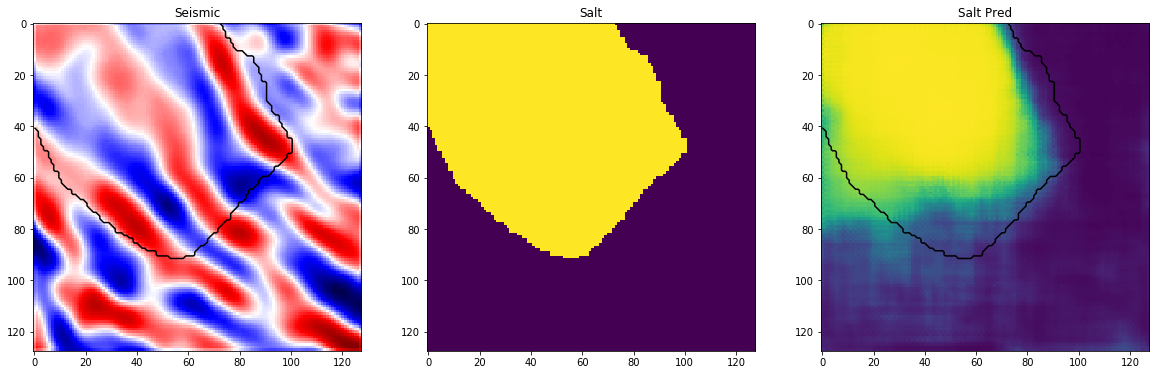

In [185]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train)

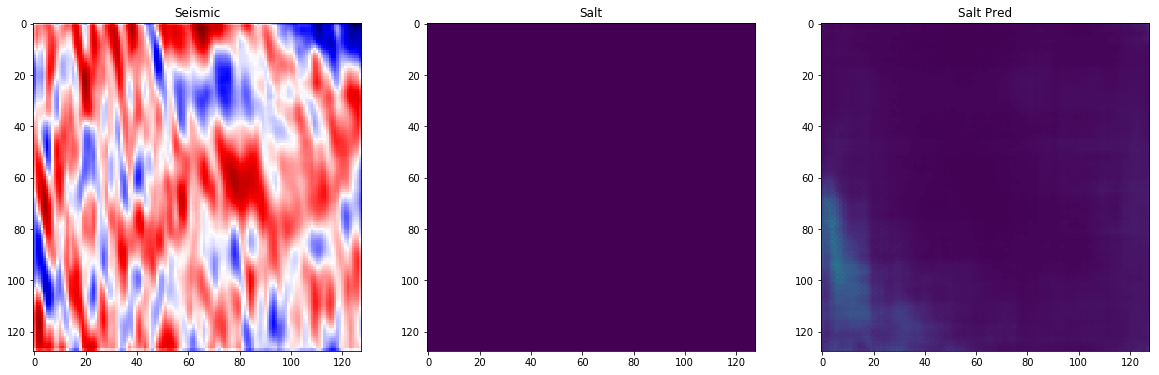

In [186]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train)

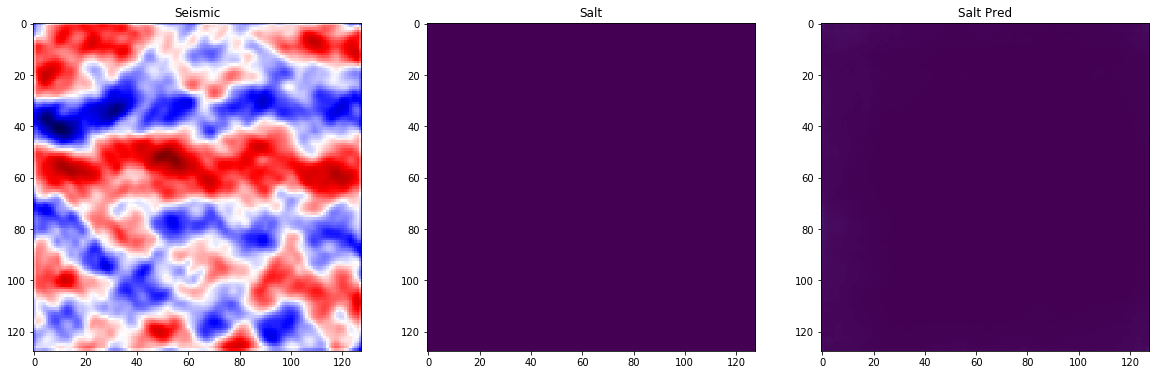

In [187]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train)

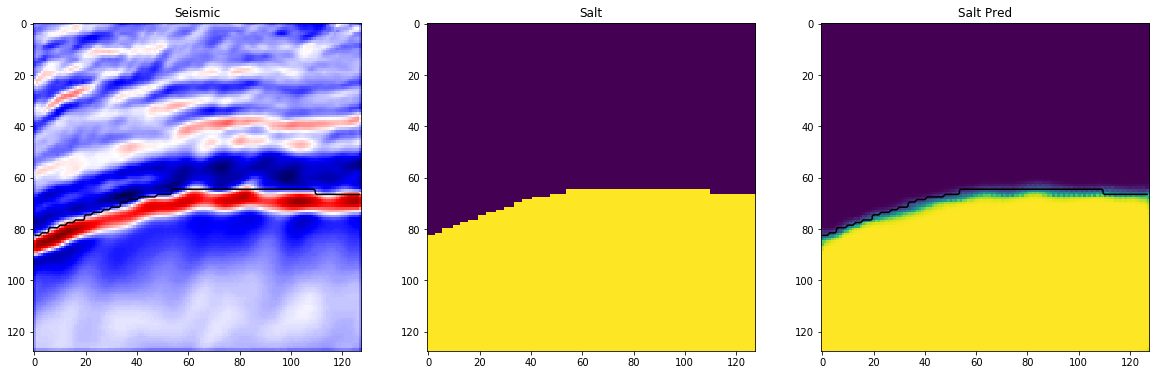

In [188]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train)

In [173]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [174]:
thres = np.linspace(0.3, 0.8, 10)
thres_ioc = [iou_metric_batch(y_valid, np.int32(preds_val > t)) for t in thres]

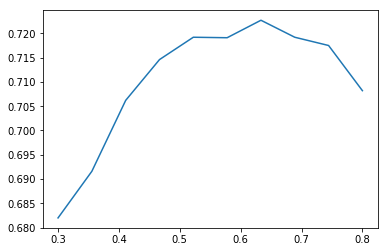

In [175]:
plt.plot(thres, thres_ioc);

In [176]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.6333333333333333, 0.7227)

In [179]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs



In [193]:
preds_test_upsampled = []
preds = preds_test > best_thres # threshold
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds[i]), (101, 101), mode='constant', preserve_range=True, anti_aliasing=True))






 36%|███▋      | 6549/18000 [00:27<00:48, 237.27it/s]

In [195]:
pred_dict = {id_[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,id_ in enumerate(test_ids)} 

In [196]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submissions/subm_002.csv')